# Import needed modules and useful functions

In [2]:
#-- necessary modules --#
import numpy as np
np.random.seed(13)
import pandas as pd
import torch
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
import matplotlib as mpl
from scipy import integrate
from scipy.interpolate import griddata

#-- to computer fes --#
from mlcvs.utils.fes import compute_fes

#-- to run process from jupyter --#
import subprocess
import os
from pathlib import Path
# execute bash command in the given folder
def execute(command, folder, background=False):
    cmd = subprocess.run(command, cwd=folder, shell=True, capture_output = True, text=True, close_fds=background)
    if cmd.returncode == 0:
        print(f'Completed: {command}')
    else:
        print(cmd.stderr)

#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [3]:
kb=0.008314
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'temp':300, 
    'beta': 1./(300*kb),
    'kbt': None,
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :70,
}
#--------------------------------------#

# Prepare input files for plumed

In [4]:
folder = "unbias_A/"
Path(folder).mkdir(parents=True, exist_ok=True)

with open(folder+"plumed.dat","w") as file:
    print("""
# vim:ft=plumed

MOLINFO STRUCTURE=input.ala2.pdb
phi: TORSION ATOMS=@phi-2
psi: TORSION ATOMS=@psi-2
ene: ENERGY

INCLUDE FILE=plumed_descriptors.data

PRINT FMT=%g STRIDE=500 FILE=COLVAR ARG=*

ENDPLUMED
""",file=file)

#-- run gromacs --#
#execute("cp script/input.* script/plumed_descriptors.data "+folder,folder=".")
#execute("./run_gromacs.sh",folder=folder)

Text(0, 0.5, '$\\psi$')

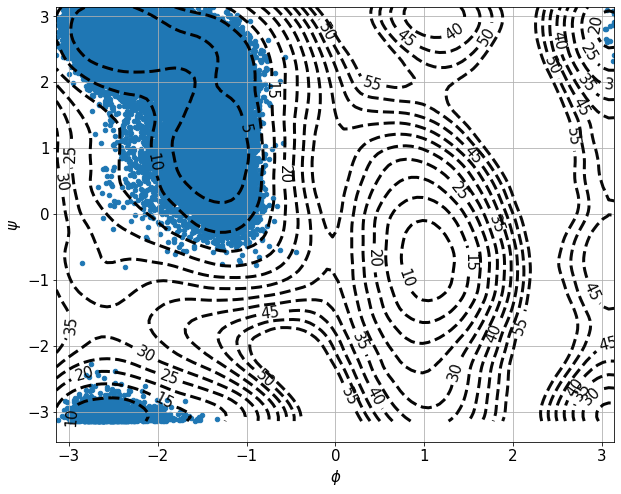

In [5]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
load_dataframe(folder+"COLVAR").plot.scatter(y="psi",x="phi",ax=ax)

fes = np.loadtxt("angles/fes.txt",delimiter=" ")
grid0 = np.loadtxt("angles/grid0.txt",delimiter=" ")
grid1 = np.loadtxt("angles/grid1.txt",delimiter=" ")
bounds = np.arange(0, 60, 5.)
c = ax.contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c.clabel()
ax.grid()
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\psi$")

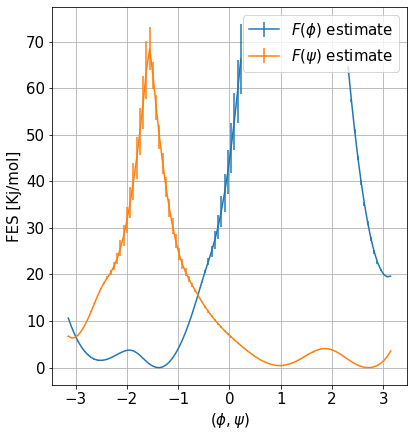

In [6]:
#-- estimation of Free Energy Surface --#
s = load_dataframe(folder+"COLVAR").filter(regex="^p").to_numpy()
logweight=np.zeros(s.shape[0])

fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend([r"$F(\phi)$ estimate",r"$F(\psi)$ estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(\phi,\psi)$")
ax.set_ylabel("FES [Kj/mol]")

plt.show()

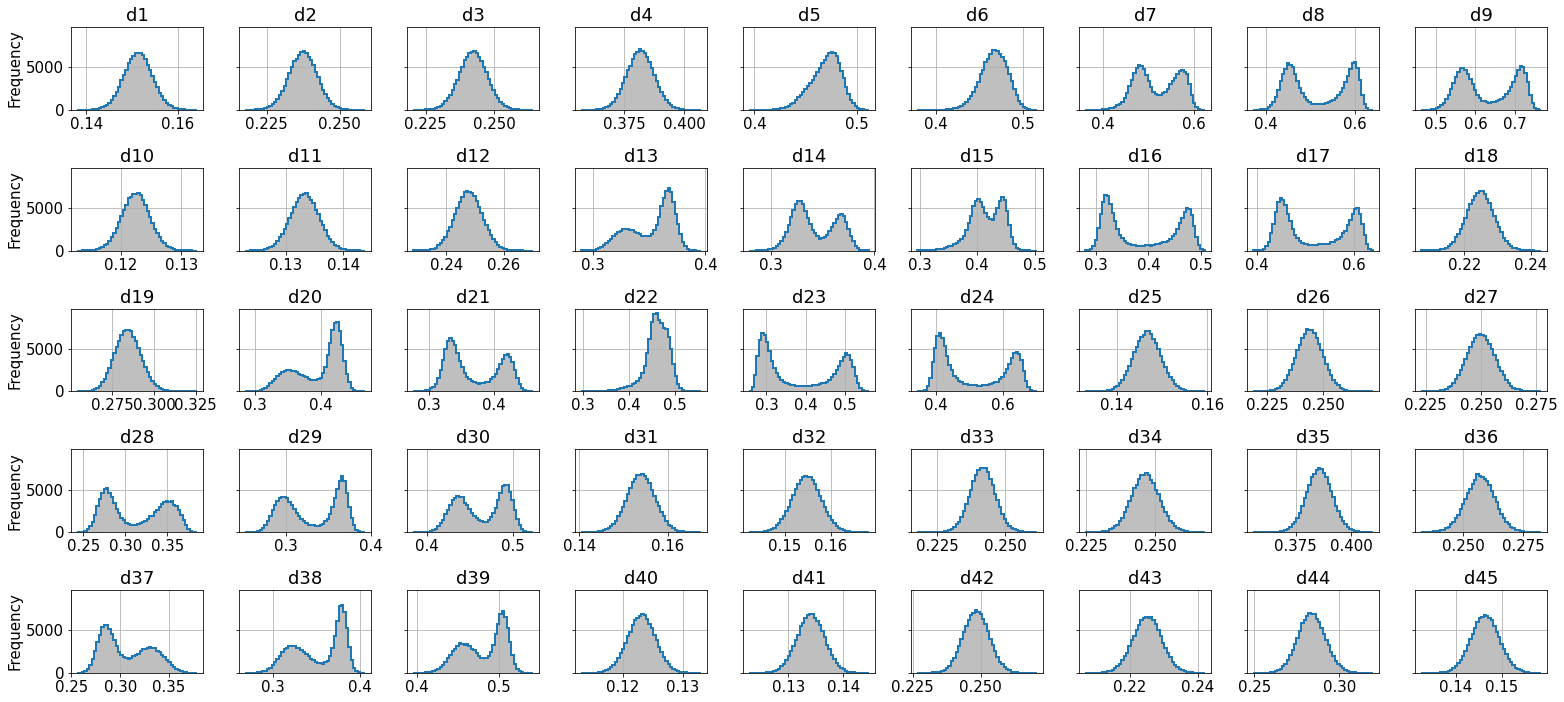

In [7]:
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^d[^a-z]').columns.values

fig,axs = plt.subplots(5,9,figsize=(22,10),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[desc].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2)#,density=True)
    data[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False,grid=True,color="grey")#,density=True)
    ax.set_title(desc)

plt.tight_layout()

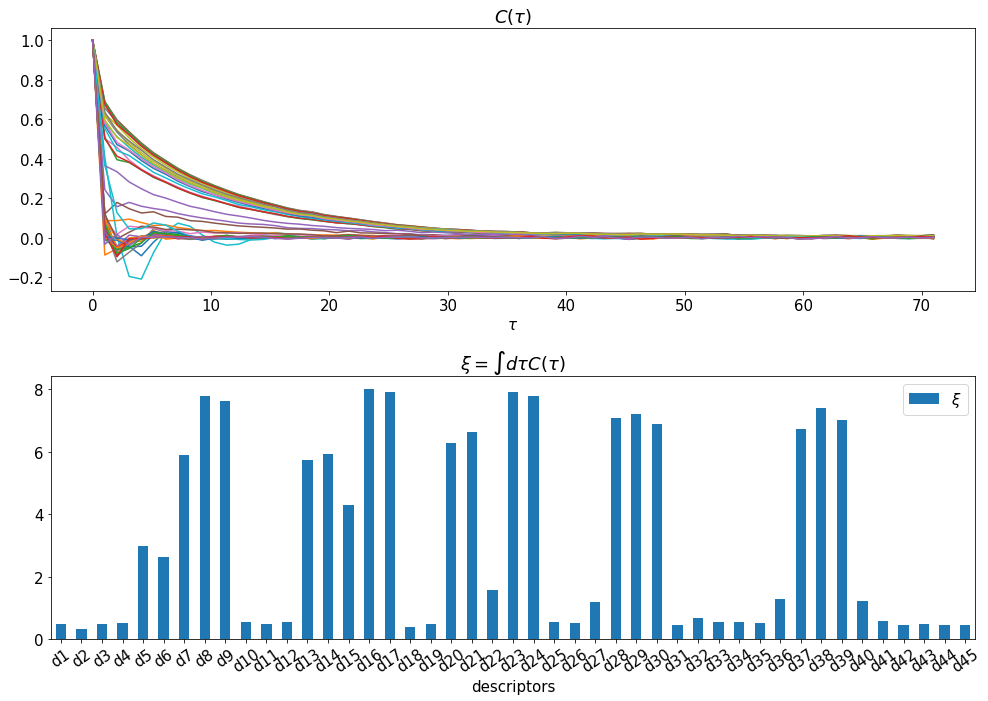

8.008649032771963
0.33276343588561735


In [8]:
fig,axs = plt.subplots(2,1,figsize=(14,10))#,sharey=True)

#-- in ps --#
last=70
x = np.linspace(0,last+1,last)
acorr = np.empty(last)
timescale = np.empty(len(descriptors_names))
k=0
for desc in descriptors_names:
    #print("autocorrelation for ", desc)
    for i in range(last):
        acorr[i] = data[desc].autocorr(i)
    axs[0].plot(x,acorr)
    timescale[k] = integrate.trapz(acorr[:last],x[:last])
    k+=1

times = pd.DataFrame(descriptors_names,columns=["descriptors"])
times["timescale"] = timescale
times.plot(kind="bar",x="descriptors",y="timescale",rot=35,ax=axs[1],fontsize=15,label=r"$\xi$")

axs[0].set_xlabel(r'$\tau$')
axs[0].set_title(r'$C(\tau)$')
axs[1].set_title(r'$\xi=\int d\tau C(\tau)$')

plt.tight_layout()
plt.show()

print(np.max(timescale))
print(np.min(timescale))

#fit_timeacorr(descriptors_names,data,axs=None)

In [9]:
#-- TRAINING PARAMETERS --#
n_output = 2
n_input = 45
train_parameters = {
              'descriptors': '^d[^a-z]',
              'nodes':[n_input,30,30,n_output], 
              'activ_type': 'tanh',
              'lag_time':10,
              'loss_type': 'sum', 
              'n_eig': n_output,
              'trainsize':0.7,
              'lrate':1e-3,
              'l2_reg':0.,
              'num_epochs':1000,
              'earlystop':True,
              'es_patience':100,
              'es_consecutive':False,
              'standardize_outputs':True,
              'standardize_inputs': True,
              'log_every':50,
              #if reweight the timescale
              "reweighting": False,
              }
#--------------------------------------#

## DeepTICA Analysis and Export

In [10]:
torch.manual_seed(21)
model,data,logweight,X = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- export checkpoint (for loading the model back to python) and torchscript traced module --#
save_folder = folder+"deeptica_lag"+str(train_parameters["lag_time"])+"/"
try:
    os.mkdir(save_folder)
except:
    print("already exists")
#-- move to cpu before saving results --#
model.to("cpu")
model.export(save_folder)
print("model saved")

#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())
print("gap: ", model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1])

no weights
Time-lagged pairs:	 99989
Training data:		 69992
Validation data:	 29997
Epoch Train Loss  Valid Loss  Eigenvalues             
50    -0.286      -0.275      0.268  0.018  
100   -0.291      -0.276      0.269  0.023  
150   -0.316      -0.295      0.271  0.041  
200   -0.336      -0.298      0.276  0.058  
INFO: Early stopping
207   -0.339      -0.299      0.276  0.060  
already exists
model saved
timescales:  [7.762498  3.5554705]
eigenvalues:  [0.27575424 0.06005061]
gap:  0.21570364


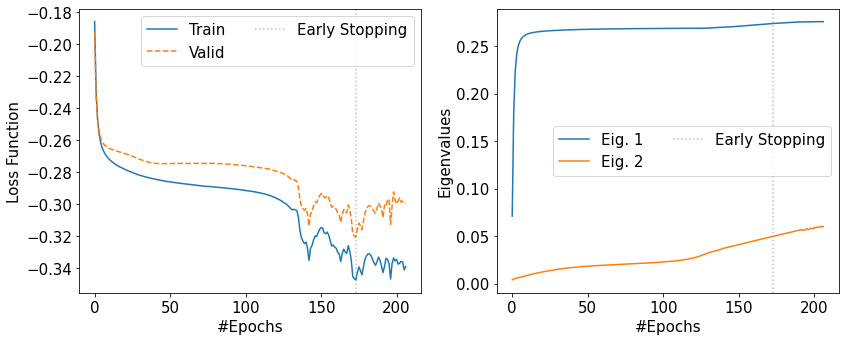

In [11]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [12]:
descriptors_names = data.filter(regex='^d[^a-z]').columns.values
data_complete = load_dataframe("angles/COLVAR")
X_complete = data_complete[descriptors_names].to_numpy()

In [13]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

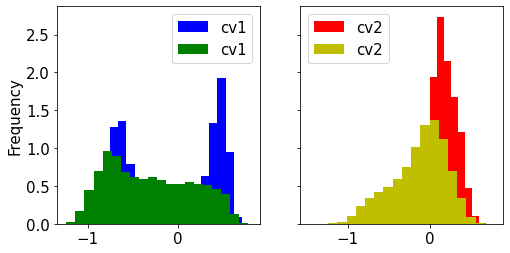

In [14]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")
data_complete.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="g")
data_complete.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="y")

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

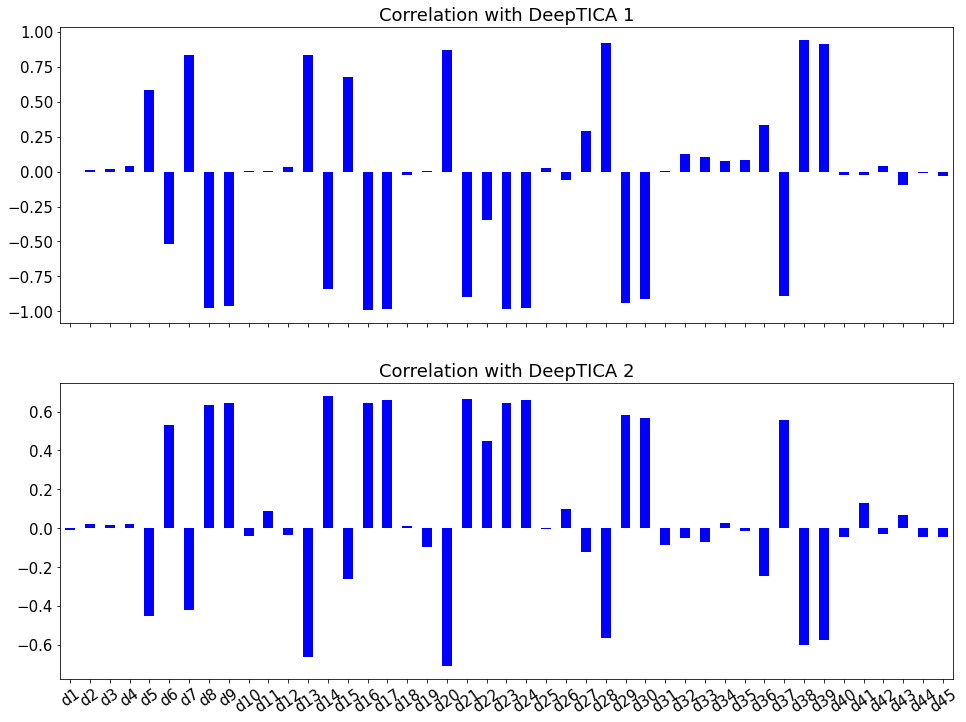

In [15]:
fig,axs = plt.subplots(2,1,figsize=(16,12),sharex=True)
for k,cv in enumerate(["cv1","cv2"]):
    cols = [cv]
    cols.extend(data.filter(regex=train_parameters["descriptors"]).columns)
    corr = data[cols].corr(method='pearson')
    corr[cv].drop(cv).plot(kind='bar', ax=axs[k], rot=35, color="b",label=r"$C(deep|desc)$")
    axs[k].set_title('Correlation with DeepTICA '+str(k+1))
plt.show()

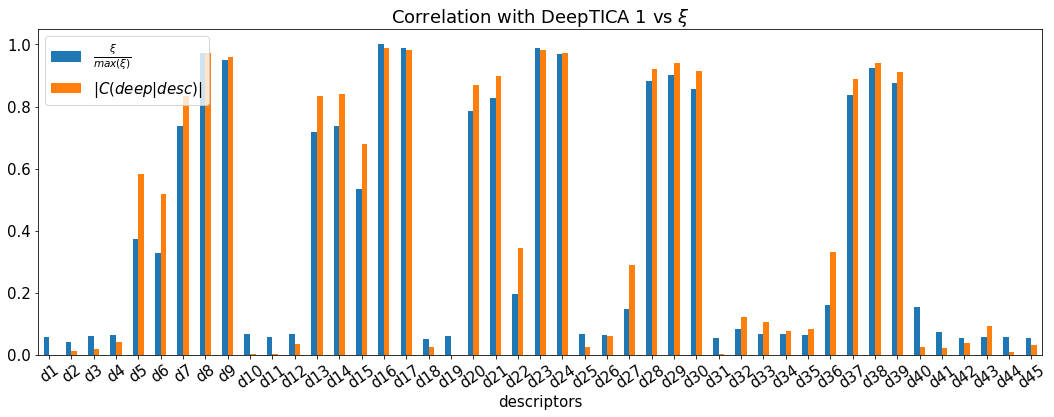

In [16]:
fig,ax = plt.subplots(1,1,figsize=(18,6))
times["timescale"] = times["timescale"]/np.max(times["timescale"])
cols = ["cv1"]
cols.extend(data.filter(regex=train_parameters["descriptors"]).columns)
corr = data[cols].corr(method='pearson')
times["corr"] = np.abs(corr["cv1"].to_numpy()[1:])
times.plot(kind="bar",x="descriptors",rot=35,ax=ax,fontsize=15,stacked=False)
ax.set_title(r'Correlation with DeepTICA 1 vs $\xi$')
ax.legend([r"$\frac{\xi}{max(\xi)}$",r"$|C(deep|desc)|$"])
plt.show()

### FES estimate from cvs  
Obviously from this first simulation it is not possible to found a cvs that from data are able to distinguish all the possible basins. I recall that our approach is a **data drive approach**.  


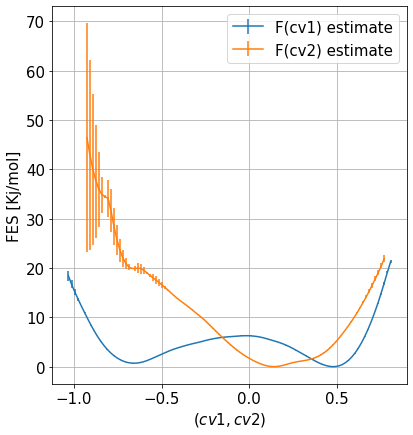

In [17]:
#-- estimation of Free Energy Surface --#
s = data.filter(regex="^cv").to_numpy()
logweight=np.zeros(s.shape[0])

fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1,cv2)$")
ax.set_ylabel("FES [Kj/mol]")

plt.show()

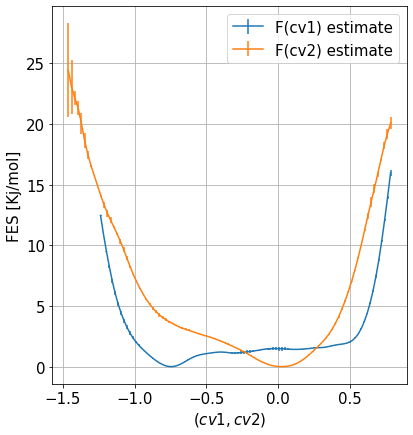

In [18]:
#-- estimation of Free Energy Surface --#
s = data_complete.filter(regex="^cv").to_numpy()
logweight=np.zeros(s.shape[0])

fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1,cv2)$")
ax.set_ylabel("FES [Kj/mol]")

plt.show()

### Isolines  
We can use the data obtained from **angles** folder, biasing both $\psi$ and $\phi$ angles, to plot the isolines of the new Cvs   

In [19]:
def plot_cvs_isolines(model,limits=((-np.pi,np.pi),(-np.pi,np.pi)),interval=50,scatter=None,path="angles/COLVAR"):

        complete_data = load_dataframe(path)
        search_values="^d[^a-z]"
        X_complete = complete_data.filter(regex=search_values).values
        x = complete_data["phi"].to_numpy()[::interval] 
        y = complete_data["psi"].to_numpy()[::interval] 

        fig,axs = plt.subplots(1,2,figsize=(12,6))

        for k,ax in enumerate(axs):
                
                #-- evaluate cvs --#
                z = np.transpose(model(torch.Tensor(X_complete)).detach().numpy())[k][::interval] 
                #-- define grid --#
                npts = len(z)
                xi = np.linspace(limits[0][0],limits[0][1],int(npts/2.))
                yi = np.linspace(limits[1][0],limits[1][1],int(npts/2.))
                #-- grid the data --#
                zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='nearest')
                #-- bounds to plot isolines --#
                bounds = np.arange(np.min(zi), np.max(zi), 0.1)
                cmap = plt.cm.get_cmap('fessa',len(bounds))
                colors = list(cmap(np.arange(len(bounds))))
                cmap = mpl.colors.ListedColormap(colors[:-1], "")
                #-- plot --#
                CS = ax.contourf(xi,yi,zi,cmap=cmap,shading='auto',alpha=1,zorder=-1,
                norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False) )
                fig.colorbar(CS, ax=ax)
                if scatter is not None:
                        ax.scatter(scatter["phi"],scatter["psi"],s=2,c='white',alpha=0.8,zorder=-1,label="scatter")
                CS = ax.contour(xi,yi,zi,shading='auto',alpha=1,zorder=-1,linewidths=3)
                ax.clabel(CS,inline=True,fmt='%1.1f',fontsize=10)
                ax.set_xlim(limits[0][0],limits[0][1])
                ax.set_ylim(limits[1][0],limits[1][1])
                ax.legend()
                ax.set_xlabel(r"$\phi$")
                ax.set_ylabel(r"$\psi$")
                ax.set_title('Deep TICA '+str(k+1))

        plt.tight_layout()
        plt.show()

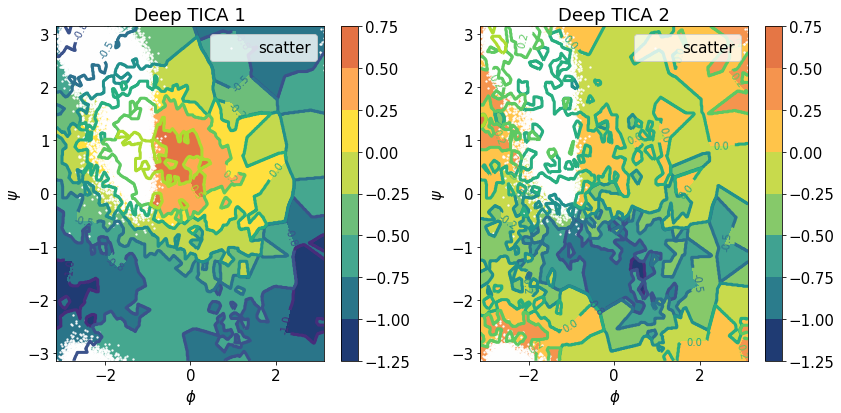

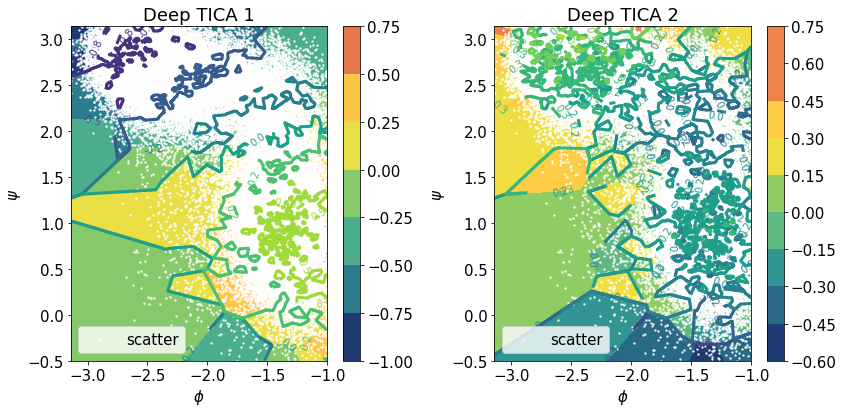

In [20]:
plot_cvs_isolines(model,limits=((-np.pi,np.pi),(-np.pi,np.pi)),interval=50,path="angles/COLVAR",scatter=data)
lim = ((-np.pi,-1),(-0.5,np.pi))
plot_cvs_isolines(model,limits=lim,interval=50,path=folder+"/COLVAR",scatter=data)

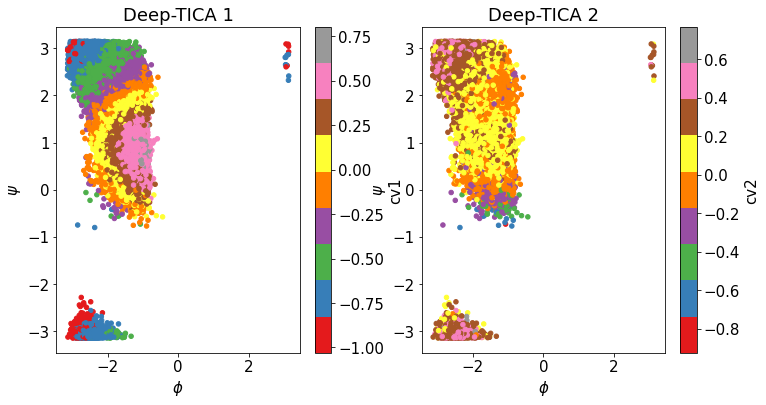

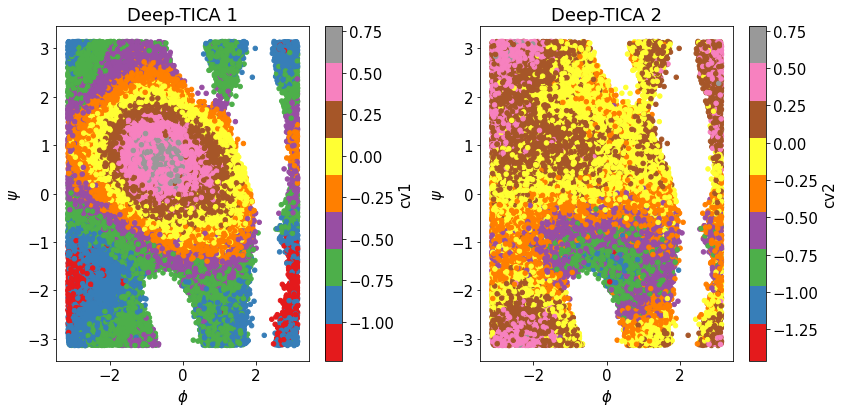

In [21]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data_complete.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [22]:
Boltzmann_product(model,model,X,j=0,k=1)

-0.0569917847063247

This results reflects the fact that we have enforce the symmetrization of $C(\tau)$  
then one can enforce the orthogonality on the data

In [23]:
#-- check scalar product --#
#DeepTICA 1
cv1 = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
#DeepTICA 2 orthogonal to DeepTICA 1
new_cv2 = orthogonal_cv(model,X)
prod = np.multiply(np.multiply(cv1,np.ones(X.shape[0])),new_cv2).mean()
print(prod)

-1.1719184822664096e-09


Text(0.5, 1.0, 'Deep-TICA 2 orthogonal')

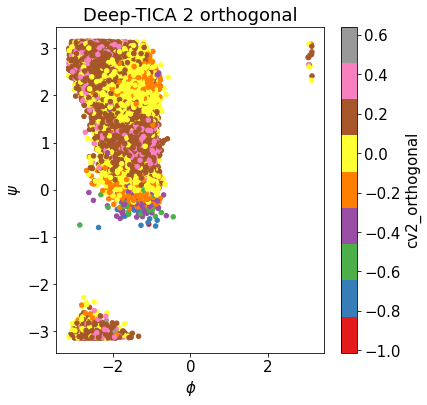

In [24]:
data["cv2_orthogonal"] = new_cv2
fig,ax = plt.subplots(1,1,figsize=(6,6))
data.plot.scatter(y="psi",x="phi",c="cv2_orthogonal",cmap="Set1",ax=ax)
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\psi$")
ax.set_title('Deep-TICA 2 orthogonal')